In [1]:
try:
   %tensorflow_version 2.x
except Exception:
   pass

TensorFlow 2.x selected.


In [0]:
%load_ext autoreload
%autoreload 2

In [0]:
import tensorflow as tf
from pathlib import Path
import os
import pandas as pd
from sklearn.model_selection import train_test_split
from functools import partial
import numpy as np
import matplotlib.pyplot as plt
from sklearn import preprocessing
import math

In [4]:
tf.__version__

'2.0.0-rc0'

In [0]:
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="0"

In [0]:
DATA_DIR = Path('data')
TEMP_DIR = Path('temp')
DATA_DIR.mkdir(parents=True, exist_ok=True)
TEMP_DIR.mkdir(parents=True, exist_ok=True)

In [7]:
!pwd

/content


In [0]:
def setup_kaggle():
  !mkdir /root/.kaggle
  !mv kaggle.json /root/.kaggle
  !chmod 600 /root/.kaggle/kaggle.json

In [0]:
setup_kaggle()

## **1. Download data, unzip, etc.**

In [10]:
!kaggle datasets download -d slothkong/10-monkey-species --unzip -p {DATA_DIR}

 98% 538M/547M [00:06<00:00, 114MB/s]
100% 547M/547M [00:06<00:00, 86.3MB/s]


In [11]:
!pwd

/content


In [12]:
%cd data
!pwd

/content/data
/content/data


In [13]:
!unzip training.zip
!unzip validation.zip
!rm training.zip
!rm validation.zip

Archive:  training.zip
   creating: training/n0/
  inflating: training/n0/n0018.jpg   
  inflating: training/n0/n0019.jpg   
  inflating: training/n0/n0020.jpg   
  inflating: training/n0/n0021.jpg   
  inflating: training/n0/n0022.jpg   
  inflating: training/n0/n0023.jpg   
  inflating: training/n0/n0024.jpg   
  inflating: training/n0/n0025.jpg   
  inflating: training/n0/n0026.jpg   
  inflating: training/n0/n0027.jpg   
  inflating: training/n0/n0028.jpg   
  inflating: training/n0/n0029.jpg   
  inflating: training/n0/n0030.jpg   
  inflating: training/n0/n0031.jpg   
  inflating: training/n0/n0032.jpg   
  inflating: training/n0/n0033.jpg   
  inflating: training/n0/n0034.jpg   
  inflating: training/n0/n0035.jpg   
  inflating: training/n0/n0036.jpg   
  inflating: training/n0/n0037.jpg   
  inflating: training/n0/n0038.jpg   
  inflating: training/n0/n0039.jpg   
  inflating: training/n0/n0040.jpg   
  inflating: training/n0/n0041.jpg   
  inflating: training/n0/n0042.jpg   
 

In [14]:
!ls -l

total 12
-rw-r--r--  1 root root  928 Sep  4 16:29 monkey_labels.txt
drwxr-xr-x 12 root root 4096 Sep  4 16:29 training
drwxr-xr-x 12 root root 4096 Sep  4 16:29 validation


In [0]:
monkey_labels = pd.read_csv('monkey_labels.txt', low_memory=False)

In [16]:
monkey_labels.head(5)

,Label,Latin Name,Common Name,Train Images,Validation Images
0,n0,alouatta_palliata\t,mantled_howler,131,26
1,n1,erythrocebus_patas\t,patas_monkey,139,28
2,n2,cacajao_calvus\t,bald_uakari,137,27
3,n3,macaca_fuscata\t,japanese_macaque,152,30
4,n4,cebuella_pygmea\t,pygmy_marmoset,131,26


In [0]:
labels = monkey_labels.Label.unique()

In [0]:
def generate_img_paths(folder, labels):
  result = []
  for label in labels:
    files = list(os.listdir('./'+folder+'/'+label.strip()+'/'))
    for file in files:
      full_path = str('./'+folder+'/'+label.strip()+'/'+file)
      result.append((label, full_path))
  return pd.DataFrame(
      result,
      columns=['Class','path']
  )

In [0]:
training_paths = generate_img_paths('training',labels)
test_paths = generate_img_paths('validation',labels)

In [20]:
training_paths.head(5)

,Class,path
0,n0,./training/n0/n0037.jpg
1,n0,./training/n0/n0163.jpg
2,n0,./training/n0/n0115.jpg
3,n0,./training/n0/n0147.jpg
4,n0,./training/n0/n0162.jpg


In [21]:
[df.shape for df in [training_paths, test_paths]]

[(1098, 2), (272, 2)]

In [22]:
training_paths.Class.value_counts(dropna=False)

n3       122
n7       114
n5       113
n1       111
n2       110
n9       106
n6       106
n8       106
n0       105
n4       105
Name: Class, dtype: int64

In [23]:
test_paths.Class.value_counts(dropna=False)

n3       30
n5       28
n7       28
n1       28
n2       27
n8       27
n6       26
n9       26
n0       26
n4       26
Name: Class, dtype: int64

Sanity check - are all links ok?

In [0]:
def path_exist(path):
  return os.path.exists(path)

training_paths['link_exists'] = training_paths.path.apply(path_exist)
test_paths['link_exists'] = test_paths.path.apply(path_exist)

In [25]:
training_paths.link_exists.value_counts(dropna=False)

True    1098
Name: link_exists, dtype: int64

In [26]:
test_paths.link_exists.value_counts(dropna=False)

True    272
Name: link_exists, dtype: int64

## **2. Train, validation, test split**

In [0]:
encoder = preprocessing.LabelEncoder()
encoder.fit(training_paths.Class)
training_paths['categorical_class'] = encoder.transform(training_paths.Class)
test_paths['categorical_class'] = encoder.transform(test_paths.Class)

In [0]:
train_df, val_df = train_test_split(training_paths, test_size=0.4, stratify=training_paths.Class)

In [29]:

print(f'Train dataframe: {train_df.shape}')
print(f'Validation dataframe: {val_df.shape}')
print(f'Test dataframe: {test_paths.shape}')


Train dataframe: (658, 4)
Validation dataframe: (440, 4)
Test dataframe: (272, 4)


In [30]:
train_df.head(5)

,Class,path,link_exists,categorical_class
1074,n9,./training/n9/n9140.jpg,True,9
824,n7,./training/n7/n7046.jpg,True,7
354,n3,./training/n3/n3073.jpg,True,3
125,n1,./training/n1/n1154.jpg,True,1
430,n3,./training/n3/n3054.jpg,True,3


## **3. Preprocess**

In [0]:
IMG_DIMS = (90,90)

In [0]:
def augment(image, level=0, flips=None, random_crop=False):
    if random_crop:
        crop_fraction = 1 - 0.05 * level
        scaled_dim = tf.to_int32(
            crop_fraction * tf.to_float(tf.reduce_min(tf.shape(image)[:2]))
        )
        image = tf.image.random_crop(image, (scaled_dim, scaled_dim, 3))
        image = tf.image.resize(image, IMG_DIMS)
    
    if flips in ["horizontal", "both"]:
        image = tf.image.random_flip_left_right(image)
    if flips in ["vertical", "both"]:
        image = tf.image.random_flip_up_down(image)
    
    if level > 0:
        lower = 1 - 0.1 * level
        upper = 1 + 0.1 * level
        image = tf.image.random_contrast(image, lower=lower, upper=upper)
        image = tf.image.random_saturation(image, lower=lower, upper=upper)
    return image

In [0]:
def image_parse(filename, preprocess_fn, img_dims, mode):
    image_string = tf.io.read_file(filename)
    image = tf.image.decode_jpeg(image_string, channels=3)
    image = (image*2-1)
    image = preprocess_fn(image)
    if mode == "stretch":
        image = tf.image.resize(image, img_dims)
    elif mode == "crop":
        image = tf.image.resize_with_crop_or_pad(image, img_dims[0], img_dims[1])
    else:
        raise ValueError("mode not implemented")
        
    return image

In [0]:
def prepare_ds(
    df,
    x,
    y,
    data_dir,
    batch_size,
    parse_fn,
    augment_fn,
    mode,
    shuffle=False,
    prefetch=1,
    num_parallel_calls=1,
):
    filenames = np.array([f"{data_dir/getattr(row, x)}" for row in df.itertuples()])
    labels = df[y].values
    
    dataset_length = len(filenames)
    preprocess_fn = partial(tf.image.convert_image_dtype, dtype=tf.float32)
    parse_fn = partial(
        parse_fn, preprocess_fn=preprocess_fn, img_dims=IMG_DIMS, mode=mode,
    )
    image_ds = (
        tf.data.Dataset.from_tensor_slices(filenames)
        .map(parse_fn, num_parallel_calls=num_parallel_calls)
        .map(augment_fn, num_parallel_calls=num_parallel_calls)
    )
    label_ds = tf.data.Dataset.from_tensor_slices(tf.cast(labels, tf.float32))
    ds = tf.data.Dataset.zip((image_ds, label_ds))
    
    if shuffle:
        ds = ds.shuffle(dataset_length)
        
    ds = ds.batch(batch_size)
    ds = ds.repeat()
    
    if prefetch:
        ds = ds.prefetch(prefetch)
    
    return ds, dataset_length, batch_size

In [0]:
train_dataset, train_dataset_length, train_batch_size = prepare_ds(
    df=train_df,
    x='path',
    y='categorical_class',
    data_dir=Path(''),
    batch_size=16,
    parse_fn=image_parse,
    augment_fn=partial(augment, level=3),
    mode="stretch",
    shuffle=True,
    prefetch=1,
    num_parallel_calls=-1,
)

In [0]:
val_dataset, val_dataset_length, val_batch_size = prepare_ds(
    df=val_df,
    x='path',
    y='categorical_class',
    data_dir=Path(''),
    batch_size=16,
    parse_fn=image_parse,
    augment_fn=augment,
    mode="stretch",
    shuffle=False,
    prefetch=1,
    num_parallel_calls=-1,
)

In [0]:
def plot_dataset(dataset, rows, cols):
  _, ax = plt.subplots(rows, cols, figsize=(5 * cols, 5 * rows))
  for i, (x,y) in enumerate(dataset.take(rows * cols)):
    ax[i // cols, i % cols].axis('off')
    ax[i // cols, i % cols].imshow(x[0])
    ax[i // cols, i % cols].set_title(y[0].numpy())

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


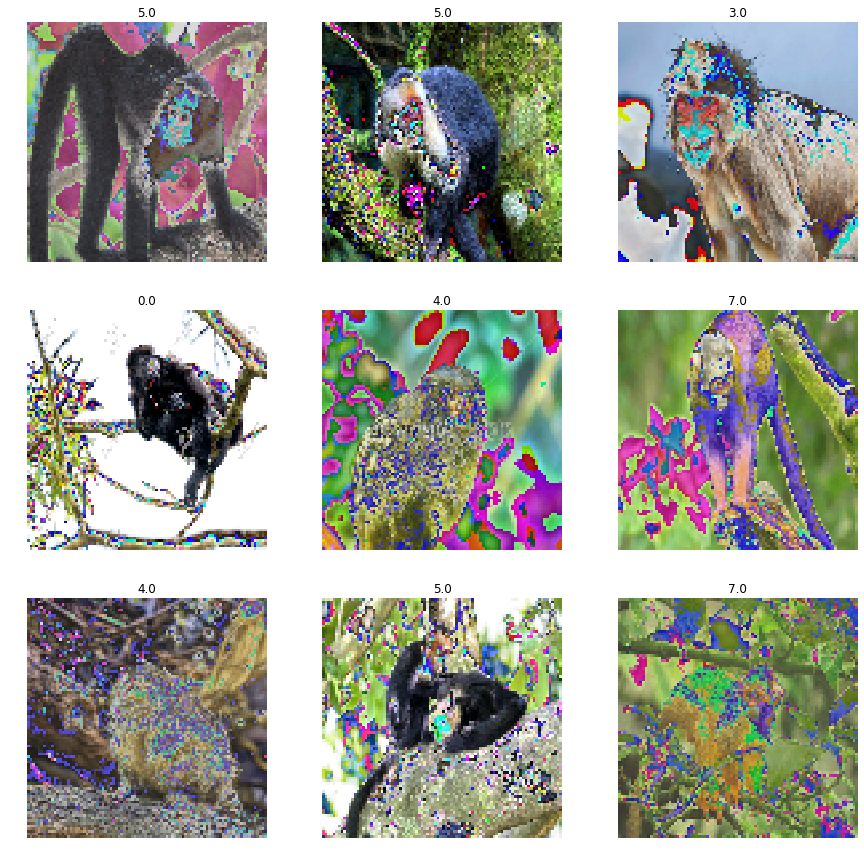

In [67]:
plot_dataset(train_dataset,3, 3)

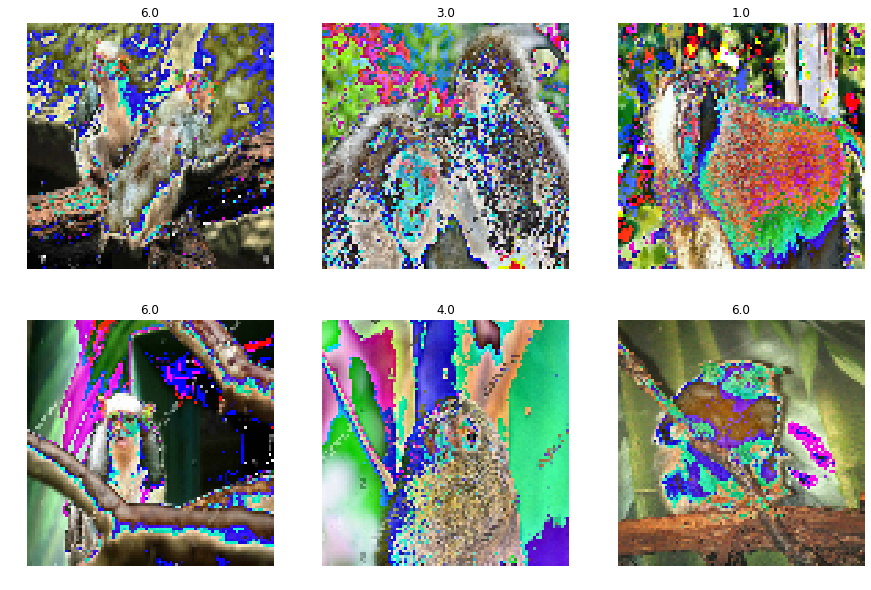

In [68]:
plot_dataset(val_dataset,2,3)

## 3. **Models**

In [0]:
n_classes = train_df.categorical_class.nunique()

Let's first build a simple model without transfer learning using a sequential api.

In [0]:
def make_model(n_layers, filters, input_shape, n_classes, l1, l2, dropout):
  model = tf.keras.models.Sequential()
  model.add(
      tf.keras.layers.Conv2D(filters[0], (5,5), input_shape=input_shape)
  )
  model.add(tf.keras.layers.BatchNormalization())
  model.add(tf.keras.layers.Activation('relu'))
  model.add(tf.keras.layers.MaxPooling2D((2,2)))
  
  if n_layers > 1:
    for i in range(n_layers-1):
      model.add(tf.keras.layers.Conv2D(filters[i+1], (5,5)))
      model.add(tf.keras.layers.BatchNormalization())
      model.add(tf.keras.layers.Activation('relu'))
      model.add(tf.keras.layers.MaxPooling2D((2,2)))
                
  model.add(tf.keras.layers.Flatten())
  model.add(tf.keras.layers.BatchNormalization())
  model.add(tf.keras.layers.Dropout(dropout))
  model.add(tf.keras.layers.Dense(
    64,
    kernel_regularizer=tf.keras.regularizers.l1_l2(l1, l2),activation='relu'))
  model.add(tf.keras.layers.BatchNormalization())
  model.add(tf.keras.layers.Dense(
      n_classes,
    activation=tf.keras.activations.softmax))
                
  return model

In [0]:
def train_model(model, optimizer, lr, epochs, easing_epochs):
    if easing_epochs:
        for layer in model.layers[:-1]:
            layer.trainable = False
            
        model.compile(
            optimizer=optimizer(lr),
            loss=tf.keras.losses.sparse_categorical_crossentropy,
            metrics=[
                tf.keras.metrics.sparse_categorical_accuracy,  
            ],
        )
        
        easing_reduce_lr_patience = max(2, easing_epochs // 3)
        easing_early_stopping_patience = easing_reduce_lr_patience * 2
        
        model.fit(
            x=train_dataset,
            steps_per_epoch=math.ceil(train_dataset_length/train_batch_size),
            validation_data=val_dataset,
            validation_steps=math.ceil(val_dataset_length/val_batch_size),
            epochs=easing_epochs,
            callbacks=[
                tf.keras.callbacks.ReduceLROnPlateau(
                    factor=0.3, patience=easing_reduce_lr_patience),
                tf.keras.callbacks.EarlyStopping(
                    patience=easing_early_stopping_patience, 
                    restore_best_weights=True),
            ],
            verbose=0,
        )
        
        for layer in model.layers[:-1]:
            layer.trainable = True
        
        
    model.compile(
        optimizer=optimizer(lr),
        loss=tf.keras.losses.sparse_categorical_crossentropy,
        metrics=[
            tf.keras.metrics.sparse_categorical_accuracy,  
        ],
    )
    
    reduce_lr_patience = max(5, epochs//4)
    early_stopping_patience = reduce_lr_patience * 2
    
    history = model.fit(
        x=train_dataset,
        steps_per_epoch=math.ceil(train_dataset_length/train_batch_size),
        validation_data=val_dataset,
        validation_steps=math.ceil(val_dataset_length/val_batch_size),
        epochs=epochs,
        callbacks=[
            tf.keras.callbacks.ReduceLROnPlateau(factor=0.3, patience=reduce_lr_patience),
            tf.keras.callbacks.EarlyStopping(patience=early_stopping_patience, restore_best_weights=True),
        ],
        verbose=1,
    )
    
    return history

In [0]:

model = make_model(
    n_layers=4,
    filters=[64,64,64,32],
    input_shape=IMG_DIMS + (3, ),
    n_classes=n_classes,
    l1=3e-3,
    l2=3e-3,
    dropout=0.4
)

In [72]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_200 (Conv2D)          (None, 86, 86, 64)        4864      
_________________________________________________________________
batch_normalization_210 (Bat (None, 86, 86, 64)        256       
_________________________________________________________________
activation_192 (Activation)  (None, 86, 86, 64)        0         
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 43, 43, 64)        0         
_________________________________________________________________
conv2d_201 (Conv2D)          (None, 39, 39, 64)        102464    
_________________________________________________________________
batch_normalization_211 (Bat (None, 39, 39, 64)        256       
_________________________________________________________________
activation_193 (Activation)  (None, 39, 39, 64)       

In [73]:
basic_model_history = train_model(
    model=model,
    optimizer=tf.keras.optimizers.Adam,
    lr=1e-4,
    epochs=20,
    easing_epochs=0,
)

Train for 42 steps, validate for 28 steps
Epoch 1/20
42/42 [==============================] - 75s 2s/step - loss: 3.7491 - sparse_categorical_accuracy: 0.0973 - val_loss: 3.2095 - val_sparse_categorical_accuracy: 0.1045
Epoch 2/20
42/42 [==============================] - 62s 1s/step - loss: 3.2812 - sparse_categorical_accuracy: 0.2006 - val_loss: 3.2383 - val_sparse_categorical_accuracy: 0.1045
Epoch 3/20
42/42 [==============================] - 62s 1s/step - loss: 3.0759 - sparse_categorical_accuracy: 0.2173 - val_loss: 3.2793 - val_sparse_categorical_accuracy: 0.1045
Epoch 4/20
42/42 [==============================] - 62s 1s/step - loss: 2.9832 - sparse_categorical_accuracy: 0.2599 - val_loss: 3.2740 - val_sparse_categorical_accuracy: 0.1045
Epoch 5/20
42/42 [==============================] - 63s 1s/step - loss: 2.8620 - sparse_categorical_accuracy: 0.3328 - val_loss: 3.2461 - val_sparse_categorical_accuracy: 0.1068
Epoch 6/20
42/42 [==============================] - 63s 2s/step - lo

In [0]:
def plot_history(history, plot_accuracy=True):
  if plot_accuracy:
    metric = history.history['sparse_categorical_accuracy']
    val_metric = history.history['val_sparse_categorical_accuracy']
    label = 'Accuracy'
    val_label = 'Validation Accuracy'
    epochs = range(1, len(metric)+1)
  else:
    metric = history.history['loss']
    val_metric = history.history['val_loss']
    epochs = range(1, len(metric)+1)
    label = 'Loss'
    val_label = 'Validation Loss'
  plt.plot(epochs, metric, 'bo', label=label)
  plt.plot(epochs, val_metric, 'b', label=val_label)
  plt.legend()
  plt.show()

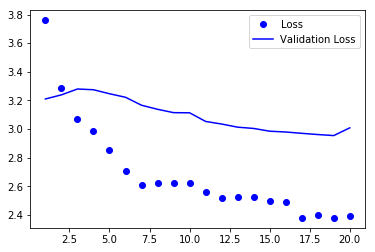

In [75]:
plot_history(basic_model_history, False)

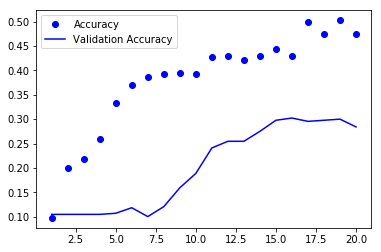

In [76]:
plot_history(basic_model_history, True)

## **Model with transfer learning**

In [0]:
def make_model_with_transfer(
  model,
  n_classes,
  dropout,
  l1,
  l2
):
  model = model
  for layer in model.layers:
    layer.trainable = False
  
  x = tf.keras.layers.concatenate([
      tf.keras.layers.GlobalAvgPool2D()(model.output),
      tf.keras.layers.GlobalMaxPool2D()(model.output),
  ])
  x = tf.keras.layers.BatchNormalization()(x)
  x = tf.keras.layers.Dropout(dropout)(x)
  x = tf.keras.layers.Dense(64, 
                         kernel_regularizer=tf.keras.regularizers.l1_l2(l1, l2),
                         activation="relu")(x)
  x = tf.keras.layers.BatchNormalization()(x)
  x = tf.keras.layers.Dense(
    n_classes,
    activation=tf.keras.activations.softmax)(x)
  
  return tf.keras.Model(inputs=model.inputs, outputs=x)

In [0]:
xception_model = make_model_with_transfer(
    model=tf.keras.applications.Xception(input_shape=IMG_DIMS + (3, ),include_top=False),
    n_classes=n_classes,
    dropout=0.4,
    l1=3e-3,
    l2=3e-3                                      
)

In [79]:
xception_model_history = train_model(
  model=xception_model,
  optimizer=tf.keras.optimizers.Adam,
  lr=1e-4,
  epochs=10,
  easing_epochs=0
)

Train for 42 steps, validate for 28 steps
Epoch 1/10
42/42 [==============================] - 92s 2s/step - loss: 17.9979 - sparse_categorical_accuracy: 0.1383 - val_loss: 17.4295 - val_sparse_categorical_accuracy: 0.1250
Epoch 2/10
42/42 [==============================] - 73s 2s/step - loss: 17.4304 - sparse_categorical_accuracy: 0.1535 - val_loss: 17.1521 - val_sparse_categorical_accuracy: 0.1227
Epoch 3/10
42/42 [==============================] - 74s 2s/step - loss: 17.0089 - sparse_categorical_accuracy: 0.1611 - val_loss: 16.8054 - val_sparse_categorical_accuracy: 0.1273
Epoch 4/10
42/42 [==============================] - 76s 2s/step - loss: 16.4702 - sparse_categorical_accuracy: 0.2082 - val_loss: 16.4886 - val_sparse_categorical_accuracy: 0.1182
Epoch 5/10
42/42 [==============================] - 74s 2s/step - loss: 16.1158 - sparse_categorical_accuracy: 0.2036 - val_loss: 16.1923 - val_sparse_categorical_accuracy: 0.1409
Epoch 6/10
42/42 [==============================] - 73s 2s

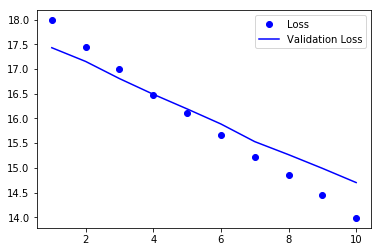

In [80]:
plot_history(xception_model_history, False)

In [0]:
inception_model = make_model_with_transfer(
    tf.keras.applications.InceptionV3(weights='imagenet', include_top=False),
    n_classes=n_classes,
    dropout=0.4,
    l1=3e-3,
    l2=3e-3 
)

In [82]:
inception_model_history = train_model(
  model=inception_model,
  optimizer=tf.keras.optimizers.Adam,
  lr=1e-4,
  epochs=10,
  easing_epochs=0,
)

Train for 42 steps, validate for 28 steps
Epoch 1/10
42/42 [==============================] - 56s 1s/step - loss: 18.0958 - sparse_categorical_accuracy: 0.1155 - val_loss: 17.6149 - val_sparse_categorical_accuracy: 0.0977
Epoch 2/10
42/42 [==============================] - 35s 831ms/step - loss: 17.7474 - sparse_categorical_accuracy: 0.1018 - val_loss: 17.3568 - val_sparse_categorical_accuracy: 0.1023
Epoch 3/10
42/42 [==============================] - 37s 872ms/step - loss: 17.4771 - sparse_categorical_accuracy: 0.1261 - val_loss: 17.1478 - val_sparse_categorical_accuracy: 0.1136
Epoch 4/10
42/42 [==============================] - 35s 845ms/step - loss: 17.1424 - sparse_categorical_accuracy: 0.1185 - val_loss: 16.9086 - val_sparse_categorical_accuracy: 0.1205
Epoch 5/10
42/42 [==============================] - 40s 950ms/step - loss: 16.7212 - sparse_categorical_accuracy: 0.1429 - val_loss: 16.6638 - val_sparse_categorical_accuracy: 0.1159
Epoch 6/10
42/42 [============================

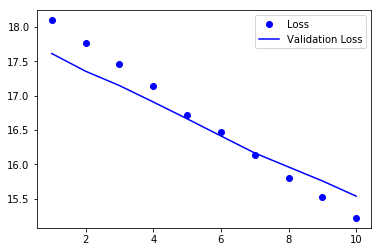

In [83]:
plot_history(inception_model_history, False)

In [84]:
inception_resnet_model = make_model_with_transfer(
    tf.keras.applications.inception_resnet_v2.InceptionResNetV2(
        weights='imagenet', include_top=False),
    n_classes=n_classes,
    dropout=0.4,
    l1=3e-3,
    l2=3e-3 
)

219062272/219055592 [==============================] - 6s 0us/step


In [85]:
inception_resnet_model_history = train_model(
  model=inception_resnet_model,
  optimizer=tf.keras.optimizers.Adam,
  lr=1e-4,
  epochs=10,
  easing_epochs=0,
)

Train for 42 steps, validate for 28 steps
Epoch 1/10
42/42 [==============================] - 79s 2s/step - loss: 16.0052 - sparse_categorical_accuracy: 0.1064 - val_loss: 15.7137 - val_sparse_categorical_accuracy: 0.1068
Epoch 2/10
42/42 [==============================] - 52s 1s/step - loss: 15.5257 - sparse_categorical_accuracy: 0.1505 - val_loss: 15.4692 - val_sparse_categorical_accuracy: 0.1318
Epoch 3/10
42/42 [==============================] - 49s 1s/step - loss: 15.2500 - sparse_categorical_accuracy: 0.1657 - val_loss: 15.3354 - val_sparse_categorical_accuracy: 0.1364
Epoch 4/10
42/42 [==============================] - 52s 1s/step - loss: 14.8299 - sparse_categorical_accuracy: 0.2052 - val_loss: 15.1184 - val_sparse_categorical_accuracy: 0.1386
Epoch 5/10
42/42 [==============================] - 52s 1s/step - loss: 14.4840 - sparse_categorical_accuracy: 0.2538 - val_loss: 14.9180 - val_sparse_categorical_accuracy: 0.1455
Epoch 6/10
42/42 [==============================] - 53s 1s

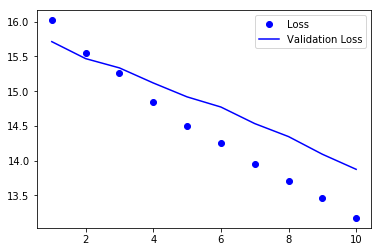

In [86]:
plot_history(inception_resnet_model_history, False)

## **Accuracy of the models**